In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
import shap

In [2]:
def short_moving_average(frame, day):
    """
    Kısa hareketli ortalama hesaplamaları için.
    """
    SMAs = []
    for i in range(frame.shape[0]):
        sma = frame[i:i+day].rolling(window=day).mean()
        sma = sma.iloc[-1,:]
        SMAs.append(sma)
    SMAs = pd.concat(SMAs, axis=1) 
    SMAs = SMAs.T
    SMAs = SMAs.dropna()
    
    return SMAs

In [3]:
def get_next_max(frame_, stock_name, start_date, end_date, next_days):
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    next_column = []
    for i in range(frame.shape[0]):
        next_column.append(frame["StockValue"][i:next_days+i].max())
        
    frame["max"] = next_column
    frame[f"max_next_{next_days}"] = (frame["max"] - frame["StockValue"]) / frame["StockValue"]
    frame = frame.iloc[:-next_days,:]
    del frame["max"]
    
    return frame

In [4]:
def get_next_min(frame_, stock_name, start_date, end_date, next_days):
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    next_column = []
    for i in range(frame.shape[0]):
        next_column.append(frame["StockValue"][i:next_days+i].min())
        
    frame["min"] = next_column
    frame[f"min_next_{next_days}"] = (frame["min"] - frame["StockValue"]) / frame["StockValue"]
    frame = frame.iloc[:-next_days,:]
    del frame["min"]
    
    return frame

In [5]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [6]:
frame_ = pd.read_pickle("frame_whole_BIST50")

In [7]:
start_date = "01-07-2010"
end_date = "31-07-2018"
stock_name = "BIMAS"

In [8]:
next_days = 20

In [10]:
datas = []
for stock_name in BIST50:
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    # NOT: Hareketli Ortalama - MA
    threshold_1 = -0.001
    frame['check_1'] = frame['MA_200_CH'] > threshold_1                  
    frame["check_1_value"] = (frame['MA_200_CH'] - threshold_1) * 100

    threshold_2 = -0.001
    frame['check_2'] = frame['MA_100_CH'] > threshold_2          
    frame["check_2_value"] = (frame['MA_100_CH'] - threshold_2) * 100

    threshold_3 = -0.001
    frame['check_3'] = frame['MA_50_CH'] > threshold_3           
    frame["check_3_value"] = (frame['MA_50_CH'] - threshold_3) * 100

    threshold_4 = -0.001
    frame['check_4'] = frame['MA_14_CH'] > threshold_4           
    frame["check_4_value"] = (frame['MA_14_CH'] - threshold_4) * 100



    threshold_5 = (frame['MA_100']*0.95)
    frame['check_5'] = frame['MA_14'] > threshold_5 
    frame["check_5_value"] = (frame['MA_14'] - threshold_5) / threshold_5

    threshold_6 = (frame['MA_200']*0.95) 
    frame['check_6'] = frame['MA_20'] > threshold_6
    frame["check_6_value"] = (frame['MA_20'] - threshold_6) / threshold_6

    # threshold_7 = (frame['MA_50']*1) 
    # frame['check_7'] = frame['MA_7'] > threshold_7
    # frame["check_7_value"] = (frame['MA_7'] - threshold_7) / threshold_7


    threshold_8 = 50
    frame['check_8'] = frame['RSI_5'] > threshold_8               
    frame["check_8_value"] = (frame['RSI_5'] - threshold_8) / threshold_8

    threshold_9 = 100
    frame['check_9'] = frame["StockValue_momentum"] > threshold_9 
    frame["check_9_value"] = (frame['StockValue_momentum'] - threshold_9) / threshold_9


    frame['check_10'] = frame["MA_7_CH_CH"] > -3      
    frame['check_11'] = frame["MA_14_CH_CH"] > -2               # -> 14 MA değerinin, 14 MA değerinin, 7 günlük trajectory
    frame['check_12'] = frame["MA_50_CH_CH"] > -1              # -> 50 MA değerinin, 14 MA değerinin, 7 günlük trajectory
    frame['check_13'] = frame["MA_100_CH_CH"] > -0.1           # -> 100 MA değerinin, 14 MA değerinin, 7 günlük trajectory
    frame['check_14'] = frame["MA_200_CH_CH"] > -0.5           # -> 200 MA değerinin, 14 MA değerinin, 7 günlük trajectory

    frame['check_15'] = frame['market_positive_ma_10'] > 0.35  # -> Markette artış gösteren hisse değerlerlerinin 10 MA değeri
    frame['check_16'] = frame['RSI_5_CH'] > -0.02              # -> RSI değerinin 5 MA değeri
    frame['check_17'] = frame['RSI_CH'] > -0.02                # -> RSI 7 günlük trajectory

    first_check_columns = ["check_1", "check_2", "check_3", "check_4"]

    second_check_columns = ["check_5", "check_6"] 

    third_check_columns = ["check_8", "check_9"]

    fourth_check_columns = ["check_10", "check_11", "check_12", "check_13", "check_14"]

    fifth_check_columns = ["check_15", "check_16", "check_17"]
    
    frame["first_check"] = frame[first_check_columns].sum(axis=1)   # sum first check categories
    frame["second_check"] = frame[second_check_columns].sum(axis=1) 
    frame["third_check"] = frame[third_check_columns].sum(axis=1)  
    frame["fourth_check"] = frame[fourth_check_columns].sum(axis=1)  
    frame["fifth_check"] = frame[fifth_check_columns].sum(axis=1)  

    frame['Recommendation'] = np.where((frame["first_check"] >= 3) &
                                       (frame["second_check"]>= 2) &
                                       (frame["third_check"] >= 1) &
                                       (frame["fourth_check"] >= 4) &
                                       (frame["fifth_check"] >= 2)
                                       ,"BUY", "SELL")
    
    locations = []
    start = 0
    for row in range(frame.shape[0]-1):
        if frame.Recommendation[row] == "BUY":
            mode = "BUY"
            if (frame.Recommendation[row] == "BUY" and frame.Recommendation[row+1] == "SELL"):
                end = row+1
                loc = [start, end]
                locations.append(loc)

        else:
            mode = "SELL"
            if (frame.Recommendation[row] == "SELL" and frame.Recommendation[row+1] == "BUY"):
                start = row+1
                
    frame["MA_14_100"] = frame["MA_14"] - frame["MA_100"]
    frame["MA_50_200"] = frame["MA_50"] - frame["MA_200"]
    frame["MA_7_50"] = frame["MA_7"] - frame["MA_50"]
    
    frames = get_next_max(frame, stock_name, start_date, end_date, next_days)
    frames = get_next_min(frames, stock_name, start_date, end_date, next_days)
    
    frames['target'] = np.where((frames[f"max_next_{next_days}"] >= 0.07) 
                            & (frames[f"min_next_{next_days}"] >= -0.1)
                            ,1,0)
    
    data = frames
    
    scaling_columns = ["MA_7", "MA_14", "MA_20", "MA_50", "MA_100","MA_200",
                       "Drawdown", "RSI_CH", "RSI_5_CH", "MA_7_CH", "MA_14_CH", 
                       "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH",
                       "volume", "volume_ma_14", "MA_14_100", "MA_50_200", "MA_7_50",
                       "StockValue_momentum"]
    
    try:
        data[scaling_columns] = scale(data[scaling_columns])
    except:
        data = data
    
    del data["stock_name"]
    del data[f"max_next_{next_days}"]
    del data[f"min_next_{next_days}"]
    del data["StockValue"]
    
    data['marketV_to_bookV'] = data['marketV_to_bookV'].astype(float)
    
    data = data[["MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH", 
             "MA_14_100", "MA_50_200","MA_7_50", "RSI_5_CH",
             "StockValue_momentum", "target", "market_positive_ma_10", "marketV_to_bookV",
             "Recommendation"]]
    
    data = pd.get_dummies(data, columns = ["Recommendation"], drop_first = True)
    datas.append(data)

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
Numerical issues were encountered 

In [14]:
data = datas

In [15]:
# Features and Target
y = data[["target"]]
targets = y

features = data.drop("target", axis=1)
X = features

In [16]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020, stratify=y)

In [17]:
# Translate these sets into XGBoost-compatible dense matrices
d_train = xgb.DMatrix(X_train.values, label=y_train.values, feature_names=X_train.columns)
d_validation = xgb.DMatrix(X_test, label=y_test.values, feature_names=X_test.columns)

In [18]:
# Parametrize a watch list to follow the training performance
watch_list = [(d_train, 'train'), (d_validation, 'validation')]

In [19]:
# Parameters
params = {"eta": 0.01, 
          "tree_method" : "hist",
          "grow_policy" : 'depthwise',
          "max_depth" : 6, 
          "subsample" : 0.9, 
          "colsample_bytree" : 0.9,
          "min_child_weight" : 1,
          "objective" : 'binary:hinge',
           # "base_score" : perc_def,
          "scale_pos_weight" : 1,
           # "n_estimators" : 1000, 
          "eval_metric" : "auc",
          "seed" : 13,
          "gamma" : 0.11,
          "nthread" : 14,
          "reg_alpha" : 0,
          "verbosity" : 1}

MODEL_NUMBER_OF_ROUNDS = 2000
MODEL_EARLY_STOPPING_ROUNDS = 500

In [20]:
model = xgb.train(params=params,
                        dtrain=d_train,
                        num_boost_round=MODEL_NUMBER_OF_ROUNDS,
                        evals=watch_list,
                        early_stopping_rounds=MODEL_EARLY_STOPPING_ROUNDS
)

[23:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	validation-auc:0.50000
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 500 rounds.
[1]	train-auc:0.50000	validation-auc:0.50000
[2]	train-auc:0.50000	validation-auc:0.50000
[3]	train-auc:0.50000	validation-auc:0.50000
[4]	train-auc:0.50000	validation-auc:0.50000
[5]	train-auc:0.50000	validation-auc:0.50000
[6]	train-auc:0.50000	validation-auc:0.50000
[7]	train-auc:0.50000	validation-auc:0.50000
[8]	train-auc:0.50000	validation-auc:0.50000
[9]	train-auc:0.50000	validation-auc:0.50000
[10]	train-auc:0.50000	validat

[166]	train-auc:0.59730	validation-auc:0.59109
[167]	train-auc:0.59749	validation-auc:0.59175
[168]	train-auc:0.59842	validation-auc:0.59344
[169]	train-auc:0.59960	validation-auc:0.59384
[170]	train-auc:0.59962	validation-auc:0.59387
[171]	train-auc:0.60010	validation-auc:0.59537
[172]	train-auc:0.60024	validation-auc:0.59560
[173]	train-auc:0.60105	validation-auc:0.59598
[174]	train-auc:0.60204	validation-auc:0.59555
[175]	train-auc:0.60228	validation-auc:0.59574
[176]	train-auc:0.60233	validation-auc:0.59534
[177]	train-auc:0.60230	validation-auc:0.59530
[178]	train-auc:0.60246	validation-auc:0.59632
[179]	train-auc:0.60310	validation-auc:0.59652
[180]	train-auc:0.60335	validation-auc:0.59569
[181]	train-auc:0.60299	validation-auc:0.59578
[182]	train-auc:0.60328	validation-auc:0.59582
[183]	train-auc:0.60330	validation-auc:0.59536
[184]	train-auc:0.60285	validation-auc:0.59523
[185]	train-auc:0.60199	validation-auc:0.59455
[186]	train-auc:0.60249	validation-auc:0.59434
[187]	train-a

[341]	train-auc:0.57638	validation-auc:0.56581
[342]	train-auc:0.57616	validation-auc:0.56576
[343]	train-auc:0.57610	validation-auc:0.56595
[344]	train-auc:0.57610	validation-auc:0.56579
[345]	train-auc:0.57579	validation-auc:0.56515
[346]	train-auc:0.57572	validation-auc:0.56503
[347]	train-auc:0.57560	validation-auc:0.56453
[348]	train-auc:0.57570	validation-auc:0.56426
[349]	train-auc:0.57530	validation-auc:0.56329
[350]	train-auc:0.57531	validation-auc:0.56327
[351]	train-auc:0.57499	validation-auc:0.56312
[352]	train-auc:0.57515	validation-auc:0.56341
[353]	train-auc:0.57500	validation-auc:0.56331
[354]	train-auc:0.57479	validation-auc:0.56290
[355]	train-auc:0.57468	validation-auc:0.56299
[356]	train-auc:0.57451	validation-auc:0.56286
[357]	train-auc:0.57458	validation-auc:0.56281
[358]	train-auc:0.57452	validation-auc:0.56251
[359]	train-auc:0.57456	validation-auc:0.56249
[360]	train-auc:0.57446	validation-auc:0.56263
[361]	train-auc:0.57421	validation-auc:0.56265
[362]	train-a

[516]	train-auc:0.56481	validation-auc:0.55591
[517]	train-auc:0.56473	validation-auc:0.55602
[518]	train-auc:0.56471	validation-auc:0.55592
[519]	train-auc:0.56461	validation-auc:0.55581
[520]	train-auc:0.56449	validation-auc:0.55564
[521]	train-auc:0.56450	validation-auc:0.55568
[522]	train-auc:0.56447	validation-auc:0.55577
[523]	train-auc:0.56442	validation-auc:0.55559
[524]	train-auc:0.56447	validation-auc:0.55567
[525]	train-auc:0.56448	validation-auc:0.55564
[526]	train-auc:0.56446	validation-auc:0.55562
[527]	train-auc:0.56438	validation-auc:0.55559
[528]	train-auc:0.56438	validation-auc:0.55560
[529]	train-auc:0.56434	validation-auc:0.55580
[530]	train-auc:0.56439	validation-auc:0.55573
[531]	train-auc:0.56438	validation-auc:0.55555
[532]	train-auc:0.56444	validation-auc:0.55566
[533]	train-auc:0.56442	validation-auc:0.55552
[534]	train-auc:0.56441	validation-auc:0.55534
[535]	train-auc:0.56434	validation-auc:0.55524
[536]	train-auc:0.56437	validation-auc:0.55524
[537]	train-a

In [22]:
best_iteration = model.best_ntree_limit
print("Best iteration: " + str(best_iteration))

Best iteration: 180


In [23]:
ypred = model.predict(d_validation, ntree_limit=best_iteration)

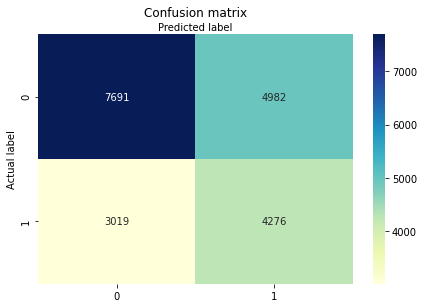

In [24]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

if params["objective"] == "binary:hinge":
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
        # create heatmap
    sn.heatmap(pd.DataFrame(confusion_matrix(y_test, ypred)), annot=True, 
                cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [25]:
fallout, sensitivity, thresholds = roc_curve(y_test, ypred)

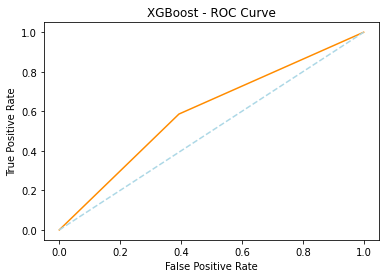

--------------------------------------------------
---------------- AUC Score: 0.597 ----------------
--------------------------------------------------


In [26]:
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color = "lightblue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.show()

from sklearn.metrics import roc_auc_score
print(50 * "-")
print(str("-" * 16) + " AUC Score: " + str(round(roc_auc_score(y_test.values , ypred),3)) + " " + str("-" * 16))
print(50 * "-")

In [27]:
def predict(xs):
    return model.predict(xgb.DMatrix(xs))

### VALIDATION

In [28]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [29]:
stock_name = "BIMAS"

In [30]:
start_date = "01-07-2018"
end_date = "31-07-2020"
stock_name = stock_name

In [31]:
frame = frame_.loc[frame_["stock_name"] == stock_name]
frame = frame.loc[frame.index > start_date]
frame = frame.loc[frame.index < end_date]

In [32]:
# NOT: Hareketli Ortalama - MA
threshold_1 = -0.001
frame['check_1'] = frame['MA_200_CH'] > threshold_1                  
frame["check_1_value"] = (frame['MA_200_CH'] - threshold_1) * 100

threshold_2 = -0.001
frame['check_2'] = frame['MA_100_CH'] > threshold_2          
frame["check_2_value"] = (frame['MA_100_CH'] - threshold_2) * 100

threshold_3 = -0.001
frame['check_3'] = frame['MA_50_CH'] > threshold_3           
frame["check_3_value"] = (frame['MA_50_CH'] - threshold_3) * 100

threshold_4 = -0.001
frame['check_4'] = frame['MA_14_CH'] > threshold_4           
frame["check_4_value"] = (frame['MA_14_CH'] - threshold_4) * 100



threshold_5 = (frame['MA_100']*0.95)
frame['check_5'] = frame['MA_14'] > threshold_5 
frame["check_5_value"] = (frame['MA_14'] - threshold_5) / threshold_5

threshold_6 = (frame['MA_200']*0.95) 
frame['check_6'] = frame['MA_20'] > threshold_6
frame["check_6_value"] = (frame['MA_20'] - threshold_6) / threshold_6

# threshold_7 = (frame['MA_50']*1) 
# frame['check_7'] = frame['MA_7'] > threshold_7
# frame["check_7_value"] = (frame['MA_7'] - threshold_7) / threshold_7


threshold_8 = 50
frame['check_8'] = frame['RSI_5'] > threshold_8               
frame["check_8_value"] = (frame['RSI_5'] - threshold_8) / threshold_8

threshold_9 = 100
frame['check_9'] = frame["StockValue_momentum"] > threshold_9 
frame["check_9_value"] = (frame['StockValue_momentum'] - threshold_9) / threshold_9


frame['check_10'] = frame["MA_7_CH_CH"] > -3      
frame['check_11'] = frame["MA_14_CH_CH"] > -2               # -> 14 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_12'] = frame["MA_50_CH_CH"] > -1              # -> 50 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_13'] = frame["MA_100_CH_CH"] > -0.1           # -> 100 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_14'] = frame["MA_200_CH_CH"] > -0.5           # -> 200 MA değerinin, 14 MA değerinin, 7 günlük trajectory

frame['check_15'] = frame['market_positive_ma_10'] > 0.35  # -> Markette artış gösteren hisse değerlerlerinin 10 MA değeri
frame['check_16'] = frame['RSI_5_CH'] > -0.02              # -> RSI değerinin 5 MA değeri
frame['check_17'] = frame['RSI_CH'] > -0.02                # -> RSI 7 günlük trajectory

first_check_columns = ["check_1", "check_2", "check_3", "check_4"]

second_check_columns = ["check_5", "check_6"] 

third_check_columns = ["check_8", "check_9"]

fourth_check_columns = ["check_10", "check_11", "check_12", "check_13", "check_14"]

fifth_check_columns = ["check_15", "check_16", "check_17"]

In [33]:
frame["first_check"] = frame[first_check_columns].sum(axis=1)   # sum first check categories
frame["second_check"] = frame[second_check_columns].sum(axis=1) 
frame["third_check"] = frame[third_check_columns].sum(axis=1)  
frame["fourth_check"] = frame[fourth_check_columns].sum(axis=1)  
frame["fifth_check"] = frame[fifth_check_columns].sum(axis=1)  

frame['Recommendation'] = np.where((frame["first_check"] >= 3) &
                                   (frame["second_check"]>= 2) &
                                   (frame["third_check"] >= 1) &
                                   (frame["fourth_check"] >= 4) &
                                   (frame["fifth_check"] >= 2)
                                   ,"BUY", "SELL")

In [34]:
locations = []
start = 0
for row in range(frame.shape[0]-1):
    if frame.Recommendation[row] == "BUY":
        mode = "BUY"
        if (frame.Recommendation[row] == "BUY" and frame.Recommendation[row+1] == "SELL"):
            end = row+1
            loc = [start, end]
            locations.append(loc)

    else:
        mode = "SELL"
        if (frame.Recommendation[row] == "SELL" and frame.Recommendation[row+1] == "BUY"):
            start = row+1

In [35]:
frame["MA_14_100"] = frame["MA_14"] - frame["MA_100"]
frame["MA_50_200"] = frame["MA_50"] - frame["MA_200"]
frame["MA_7_50"] = frame["MA_7"] - frame["MA_50"]

In [36]:
frames = get_next_max(frame, stock_name, start_date, end_date, next_days)
frames = get_next_min(frames, stock_name, start_date, end_date, next_days)

In [37]:
data = frames

In [38]:
scaling_columns = ["MA_7", "MA_14", "MA_20", "MA_50", "MA_100", 
             "MA_200",
    "Drawdown", "RSI_CH", "RSI_5_CH", "MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH",
"volume", "volume_ma_14", "MA_14_100", "MA_50_200", "MA_7_50"]

In [39]:
data[scaling_columns] = scale(data[scaling_columns])

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


In [40]:
max_next = data[f"max_next_{next_days}"]
min_next = data[f"min_next_{next_days}"]

In [41]:
data['target'] = np.where((data[f"max_next_{next_days}"] >= 0.07) 
                            & (data[f"min_next_{next_days}"] >= -0.1)
                            ,1,0)

In [42]:
target = data["target"]

In [43]:
del data["stock_name"]
del data[f"max_next_{next_days}"]
del data[f"min_next_{next_days}"]
del data["StockValue"]
# del data["StockValue_momentum"]
# del data["MA_7"]
# del data["MA_14"]
# del data["MA_20"]
# del data["MA_50"]
# del data["MA_100"]
# del data["MA_200"]
# del data["Recommendation"]

In [44]:
data['marketV_to_bookV'] = data['marketV_to_bookV'].astype(float)

In [45]:
data = data[["MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH", 
             "MA_14_100", "MA_50_200","MA_7_50", "RSI_5_CH",
             "StockValue_momentum", "target", "market_positive_ma_10", "marketV_to_bookV",
             "Recommendation"]]

In [46]:
data = pd.get_dummies(data, columns = ["Recommendation"], drop_first = True)

In [47]:
prediction = predict(data)

ValueError: feature_names mismatch: ['MA_7_CH', 'MA_14_CH', 'MA_20_CH', 'MA_50_CH', 'MA_100_CH', 'MA_200_CH', 'MA_14_100', 'MA_50_200', 'MA_7_50', 'RSI_5_CH', 'StockValue_momentum', 'market_positive_ma_10', 'marketV_to_bookV', 'Recommendation_SELL'] ['MA_7_CH', 'MA_14_CH', 'MA_20_CH', 'MA_50_CH', 'MA_100_CH', 'MA_200_CH', 'MA_14_100', 'MA_50_200', 'MA_7_50', 'RSI_5_CH', 'StockValue_momentum', 'target', 'market_positive_ma_10', 'marketV_to_bookV', 'Recommendation_SELL']
training data did not have the following fields: target

In [48]:
data["prediction"] = prediction

NameError: name 'prediction' is not defined

In [49]:
data[f"max_next_{next_days}"] = max_next
data[f"min_next_{next_days}"] = min_next

In [50]:
data["net"] = data[f"max_next_{next_days}"] - abs(data[f"min_next_{next_days}"])

In [1293]:
data.shape

(573, 19)

In [1294]:
data.loc[data.prediction==1].tail(50)

,MA_7_CH,MA_14_CH,MA_20_CH,MA_50_CH,MA_100_CH,MA_200_CH,MA_14_100,MA_50_200,MA_7_50,RSI_5_CH,StockValue_momentum,target,market_positive_ma_10,marketV_to_bookV,Recommendation_SELL,prediction,max_next_20,min_next_20,net
2019-04-19,-0.497576,-0.574937,-0.702056,-0.002366,0.491962,-0.565928,0.012094,0.392004,-0.543475,0.315238,96.062992,0,0.482448,2.276479,1,1.0,0.000000,-0.200820,-0.200820
2019-04-22,-0.402621,-0.556353,-0.662927,-0.027371,0.461386,-0.567602,-0.003041,0.392067,-0.528937,0.229054,96.200000,0,0.499678,2.243825,1,1.0,0.000000,-0.189189,-0.189189
2019-04-24,-0.370075,-0.543373,-0.631120,-0.062285,0.421888,-0.572723,-0.022373,0.388874,-0.516800,0.134522,94.023904,0,0.474990,2.201840,1,1.0,0.000000,-0.173729,-0.173729
2019-04-25,-0.471980,-0.614844,-0.650968,-0.124365,0.374296,-0.584869,-0.069265,0.381420,-0.523365,-0.164715,85.822306,0,0.460056,2.117872,1,1.0,0.011013,-0.147577,-0.136564
2019-04-26,-0.580361,-0.669619,-0.676000,-0.169868,0.329636,-0.593240,-0.110725,0.376270,-0.532139,-0.387296,87.262357,0,0.488324,2.141196,1,1.0,0.000000,-0.156863,-0.156863
2019-04-29,-0.686488,-0.712320,-0.713134,-0.219677,0.287345,-0.588438,-0.155972,0.367450,-0.562464,-0.660950,86.206897,0,0.485021,2.099212,1,1.0,0.000000,-0.148889,-0.148889
2019-04-30,-0.809422,-0.760177,-0.747068,-0.268085,0.240673,-0.584791,-0.204183,0.357318,-0.611106,-0.952505,84.865900,0,0.489090,2.066558,1,1.0,0.000000,-0.137698,-0.137698
2019-05-02,-0.916260,-0.761327,-0.775064,-0.325282,0.191163,-0.577625,-0.240066,0.342237,-0.671116,-1.182325,87.676768,0,0.440421,2.024574,1,1.0,0.000000,-0.119816,-0.119816
2019-05-03,-1.000501,-0.753612,-0.786886,-0.379686,0.149052,-0.564445,-0.268605,0.326753,-0.732055,-0.893663,89.684211,0,0.415203,1.987254,1,1.0,0.000000,-0.103286,-0.103286
2019-05-06,-1.062588,-0.767143,-0.822712,-0.446580,0.113832,-0.538684,-0.299020,0.308744,-0.782555,-0.749235,89.384289,0,0.399992,1.963930,1,1.0,0.004751,-0.092637,-0.087886


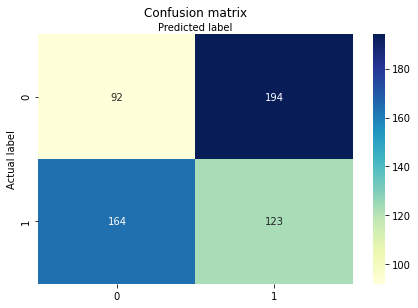

In [1295]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

if params["objective"] == "binary:hinge":
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
        # create heatmap
    sn.heatmap(pd.DataFrame(confusion_matrix(target, prediction)), annot=True, 
                cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

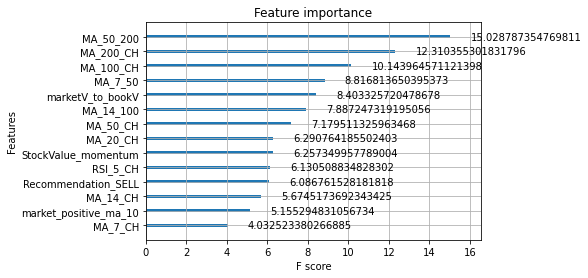

In [1296]:
xgb.plot_importance(model, importance_type = "gain")

In [1124]:
data

,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_14_100,MA_50_200,MA_7_50,RSI_5_CH,StockValue_momentum,market_positive_ma_10,marketV_to_bookV,Recommendation_SELL,prediction,max_next_20,min_next_20,net
2018-01-08,-0.718655,-0.754964,-0.807160,-0.789083,-0.842062,-1.463866,-0.093146,0.756897,0.025199,0.052681,101.468819,0.612581,7.800722,0,1.0,0.017105,-0.026316,-0.009211
2018-01-09,-0.737661,-0.747133,-0.793306,-0.790397,-0.835494,-1.451758,-0.088394,0.733589,-0.026864,-0.201030,101.735624,0.573392,7.821250,0,1.0,0.014438,-0.028870,-0.014432
2018-01-10,-0.762603,-0.734482,-0.787763,-0.791803,-0.829473,-1.440192,-0.072694,0.710996,-0.096049,-0.297811,102.841900,0.552712,7.800722,0,1.0,0.017105,-0.048027,-0.030922
2018-01-11,-0.811301,-0.743217,-0.782434,-0.798408,-0.827376,-1.428999,-0.094465,0.677731,-0.220719,-0.408735,98.119374,0.581265,7.764798,0,1.0,0.021811,-0.048249,-0.026438
2018-01-12,-0.832680,-0.748337,-0.783073,-0.805284,-0.825479,-1.417697,-0.108393,0.643688,-0.264727,-0.506538,98.885199,0.559143,7.739138,0,1.0,0.025201,-0.045092,-0.019891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,1.629877,1.691954,1.701704,1.683185,1.719645,2.103655,0.501520,0.106470,0.229819,-0.408291,96.807512,0.646371,6.690170,1,0.0,0.098933,-0.023278,0.075655
2020-04-14,1.670758,1.693210,1.757459,1.692481,1.734396,2.118219,0.478344,0.102082,0.324361,-0.393862,100.193237,0.631102,6.729104,0,0.0,0.092575,-0.028930,0.063645
2020-04-15,1.766147,1.720854,1.801477,1.713218,1.754779,2.133571,0.500020,0.121240,0.547530,-0.117483,104.234841,0.610823,7.027599,0,0.0,0.046168,-0.070175,-0.024007
2020-04-16,1.883091,1.778656,1.822818,1.735573,1.774056,2.147862,0.586140,0.145707,0.829401,0.199050,109.200000,0.638648,7.086000,0,0.0,0.037546,-0.077839,-0.040293
